# Goal

__Question:__ how is incorporator identification accuracy affected by the percent isotope incorporation of taxa?

* Using genome dataset created in the "dataset" notebook

* Simulates isotope dilution or short incubations
  * Method  
    * 25% taxa incorporate
    * incorporation % same for all incorporators
    * incorporation % treatments: 0, 20, 40, 60, 80, 100%
    * Total treatments: 6

# User variables

In [9]:
workDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/'
buildDir = os.path.join(workDir, 'percIncorpUnif')
genomeDir = '/home/nick/notebook/SIPSim/dev/bac_genome1210/genomes/'
R_dir = '/home/nick/notebook/SIPSim/lib/R/'

# Init

In [4]:
import glob
from os.path import abspath
import nestly
from IPython.display import Image, display

In [5]:
%load_ext rpy2.ipython

In [6]:
%%R
library(ggplot2)
library(dplyr)
library(tidyr)
library(gridExtra)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: grid


In [7]:
if not os.path.isdir(buildDir):
    os.makedirs(buildDir)

# Creating input files (eg., fragments & communities)

## Simulating fragments

In [169]:
!cd $buildDir; \
    SIPSim fragments \
    $genomeDir/genome_index.txt \
    --fp $genomeDir \
    --fr ../../515F-806R.fna \
    --fld skewed-normal,9000,2500,-5 \
    --flr None,None \
    --nf 10000 \
    --np 24 \
    2> ampFrags.log \
    > ampFrags.pkl        

## Converting to kde object

In [170]:
!cd $buildDir; \
    SIPSim fragment_kde \
    ampFrags.pkl \
    > ampFrags_kde.pkl

## Adding diffusion

In [172]:
!cd $buildDir; \
    SIPSim diffusion \
    ampFrags_kde.pkl \
    --np 24 \
    > ampFrags_kde_dif.pkl    

Processing: Vibrio_vulnificus_MO6-24_O
Processing: Dyella_japonica_A8
Processing: Citrobacter_koseri_ATCC_BAA-895
Processing: Leisingera_methylohalidivorans_DSM_14336
Processing: Arthrobacter_arilaitensis_Re117
Processing: Veillonella_parvula_DSM_2008
Processing: Rhodococcus_jostii_RHA1
Processing: Croceibacter_atlanticus_HTCC2559
Processing: Corynebacterium_diphtheriae_C7_beta
Processing: Borrelia_burgdorferi_ZS7
Processing: Desulfovibrio_salexigens_DSM_2638
Processing: Glaciecola_psychrophila_170
Processing: Mycoplasma_haemocanis_str_Illinois
Processing: Hyphomicrobium_nitrativorans_NL23
Processing: Pedobacter_heparinus_DSM_2366
Processing: Candidatus_Rickettsia_amblyommii_str_GAT-30V
Processing: Beutenbergia_cavernae_DSM_12333
Processing: Chlorobaculum_parvum_NCIB_8327
Processing: Spiroplasma_diminutum_CUAS-1
Processing: Bifidobacterium_adolescentis_ATCC_15703
Processing: Morganella_morganii_subsp_morganii_KT
Processing: Caldisericum_exile_AZM16c01
Processing: Spiroplasma_taiwanense

## Creating a community file

In [173]:
!cd $buildDir; \
    SIPSim communities \
    $genomeDir/genome_index.txt \
    --n_comm 2 \
    > comm.txt

# Using nestly: different incorporation percentages

In [192]:
# building tree structure
nest = nestly.Nest()

## varying params
nest.add('percIncorp', range(0,101,20))

## set params
nest.add('np_many', [24], create_dir=False)
nest.add('np_few', [8], create_dir=False)
nest.add('percTaxa', [25], create_dir=False)
nest.add('abs', ['1e10'], create_dir=False)
#nest.add('subsample', [20000], create_dir=False) 
nest.add('subsample_mean', [30000], create_dir=False) 
nest.add('subsample_scale', [5000], create_dir=False) 
nest.add('BD_min', [1.71], create_dir=False)
nest.add('BD_max', [1.78], create_dir=False)
nest.add('padj', [0.1], create_dir=False)
nest.add('log2', [0.25], create_dir=False)
nest.add('topTaxaToPlot', [100], create_dir=False)

## input/output files
nest.add('buildDir', [buildDir], create_dir=False)
nest.add('frag_file', ['ampFrags_kde_dif'], create_dir=False)
nest.add('comm_file', ['comm.txt'], create_dir=False)
nest.add('genome_index', [os.path.join(genomeDir, 'genome_index.txt')], create_dir=False)
nest.add('genome_dir', [genomeDir], create_dir=False)
nest.add('primers', [os.path.join(workDir, '../', '515F-806R.fna')], create_dir=False)
nest.add('R_dir', [R_dir], create_dir=False)

# building directory tree
nest.build(buildDir)

In [193]:
bashFile = os.path.join(workDir, 'SIPSimRun.sh')

In [194]:
%%writefile $bashFile
#!/bin/bash

# symlinking input files
ln -s {buildDir}/{frag_file}.pkl {frag_file}.pkl
ln -s {buildDir}/{comm_file} {comm_file}


# making incorp file
SIPSim incorpConfigExample \
  --percTaxa {percTaxa} \
  --percIncorpUnif {percIncorp} \
  > {percTaxa}_{percIncorp}.config

# adding isotope incorporation to BD distribution
SIPSim isotope_incorp \
    {frag_file}.pkl \
    {percTaxa}_{percIncorp}.config \
    --comm {comm_file} \
    --np {np_many} \
    > {frag_file}_incorp.pkl
 
# calculating BD shift from isotope incorporation
SIPSim BD_shift \
    {frag_file}.pkl \
    {frag_file}_incorp.pkl \
    --np {np_few} \
    > {frag_file}_incorp_BD-shift.txt
       
# simulating gradient fractions
SIPSim gradient_fractions \
    {comm_file} \
    > fracs.txt

# simulating an OTU table
SIPSim OTU_table \
    {frag_file}_incorp.pkl \
    {comm_file} \
    fracs.txt \
    --abs {abs} \
    --np {np_few} \
    > OTU_abs{abs}.txt
    
# subsampling from the OTU table (simulating sequencing of the DNA pool)
SIPSim OTU_subsample \
    --dist normal \
    --dist_params loc:{subsample_mean},scale:{subsample_scale} \
    OTU_abs{abs}.txt \
    > OTU_n2_abs{abs}_sub-norm.txt

# making a wide table
SIPSim OTU_wideLong -w \
    OTU_n2_abs{abs}_sub-norm.txt \
    > OTU_n2_abs{abs}_sub-norm_w.txt
    
# making metadata (phyloseq: sample_data)
SIPSim OTU_sampleData \
    OTU_n2_abs{abs}_sub-norm.txt \
    > OTU_n2_abs{abs}_sub-norm_meta.txt

Overwriting /home/nick/notebook/SIPSim/dev/bac_genome1210/SIPSimRun.sh


In [195]:
!chmod 775 $bashFile

In [ ]:
!cd $workDir; \
    nestrun -j 1 --template-file $bashFile -d percIncorpUnif --log-file log.txt

2015-07-17 14:35:20,278 * INFO * Template: ./SIPSimRun.sh
2015-07-17 14:35:20,280 * INFO * [86408] Started ./SIPSimRun.sh in percIncorpUnif/80


In [ ]:
%%writefile $bashFile
#!/bin/bash

#-- R analysis --#
export PATH={R_dir}:$PATH
# plotting taxon abundances
OTU_taxonAbund.r \
    OTU_n2_abs{abs}.txt \
    -r {topTaxaToPlot} \
    -o OTU_n2_abs{abs}
# plotting taxon abundances
OTU_taxonAbund.r \
    OTU_n2_abs{abs}_sub-norm.txt \
    -r {topTaxaToPlot} \
    -o OTU_n2_abs{abs}_subsub-norm
# running DeSeq2 and making confusion matrix on predicting incorporators
## making phyloseq object from OTU table
phyloseq_make.r \
    OTU_n2_abs{abs}_sub-norm_w.txt \
    -s OTU_n2_abs{abs}_sub-norm_meta.txt \
    > OTU_n2_abs{abs}_sub-norm.physeq
## filtering phyloseq object to just taxa/samples of interest
phyloseq_edit.r \
    OTU_n2_abs{abs}_sub-norm.physeq \
    --BD_min {BD_min} --BD_max {BD_max} \
    > OTU_n2_abs{abs}_sub-norm_filt.physeq
## making ordination
phyloseq_ordination.r \
    OTU_n2_abs{abs}_sub-norm_filt.physeq \
    OTU_n2_abs{abs}_sub-norm_bray-NMDS.pdf
## DESeq2
phyloseq_DESeq2.r \
    OTU_n2_abs{abs}_sub-norm_filt.physeq \
    --log2 {log2} \
    --hypo greater \
    > OTU_n2_abs{abs}_sub-norm_DESeq2
## Confusion matrix
DESeq2_confuseMtx.r \
    {frag_file}_incorp_BD-shift.txt \
    OTU_n2_abs{abs}_sub-norm_DESeq2 \
    --padj {padj} 

In [219]:
!chmod 775 $bashFile

In [220]:
!cd $workDir; \
    nestrun -j 20 --template-file $bashFile -d percIncorpUnif --log-file log.txt

2015-07-18 09:19:00,544 * INFO * Template: ./SIPSimRun.sh
2015-07-18 09:19:00,546 * INFO * [113400] Started ./SIPSimRun.sh in percIncorpUnif/80
2015-07-18 09:19:00,548 * INFO * [113401] Started ./SIPSimRun.sh in percIncorpUnif/20
2015-07-18 09:19:00,549 * INFO * [113403] Started ./SIPSimRun.sh in percIncorpUnif/0
2015-07-18 09:19:00,551 * INFO * [113407] Started ./SIPSimRun.sh in percIncorpUnif/60
2015-07-18 09:19:00,552 * INFO * [113413] Started ./SIPSimRun.sh in percIncorpUnif/100
2015-07-18 09:19:00,554 * INFO * [113420] Started ./SIPSimRun.sh in percIncorpUnif/40
2015-07-18 09:19:04,901 * INFO * [113403] percIncorpUnif/0 Finished with 0
2015-07-18 09:19:05,011 * INFO * [113401] percIncorpUnif/20 Finished with 0
2015-07-18 09:19:05,392 * INFO * [113420] percIncorpUnif/40 Finished with 0
2015-07-18 09:19:05,415 * INFO * [113407] percIncorpUnif/60 Finished with 0
2015-07-18 09:19:05,444 * INFO * [113413] percIncorpUnif/100 Finished with 0
2015-07-18 09:19:05,465 * INFO * [113400] perc

In [ ]:
# aggregating confusion matrix data
## table
!cd $workDir; \
    nestagg delim \
        -d percIncorpUnif \
        -k percIncorp \
        -o ./percIncorpUnif/DESeq2-cMtx_table.csv \
        DESeq2-cMtx_table.csv

## overall
!cd $workDir; \
    nestagg delim \
        -d percIncorpUnif \
        -k percIncorp \
        -o ./percIncorpUnif/DESeq2-cMtx_overall.csv \
        DESeq2-cMtx_overall.csv
    
## byClass
!cd $workDir; \
    nestagg delim \
        -d percIncorpUnif \
        -k percIncorp \
        -o ./percIncorpUnif/DESeq2-cMtx_byClass.csv \
        DESeq2-cMtx_byClass.csv

### Taxon abundance plots

#### Converting image files

In [222]:
x = os.path.join(workDir, 'percIncorpUnif', '*', 'OTU*abund.pdf')
abundFiles = glob.glob(x)

for x in abundFiles:
    base = os.path.splitext(x)[0]
    !cd $buildDir; convert $base\.pdf $base\.png

#### OTU tables: full counts

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/0/OTU_abs1e10_abs-abund.png


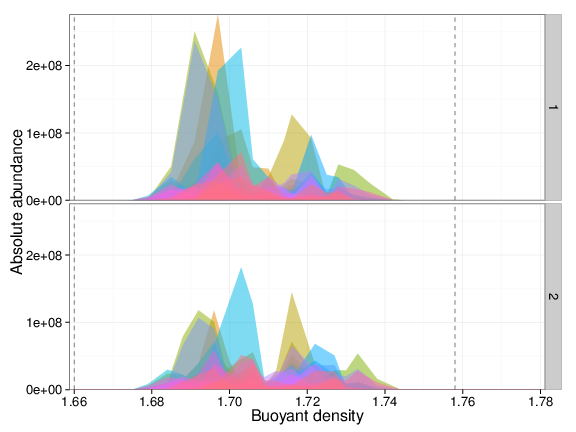

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/0/OTU_abs1e10_rel-abund.png


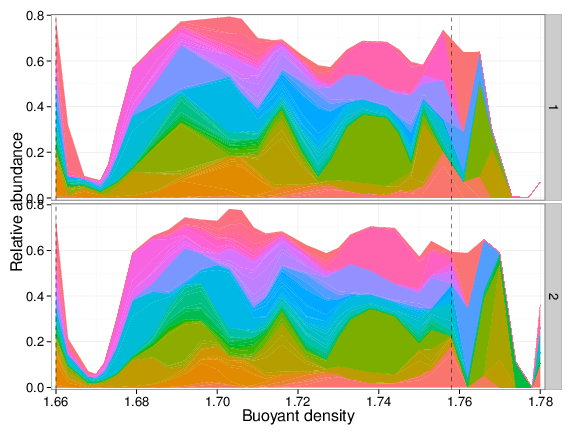

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/100/OTU_abs1e10_abs-abund.png


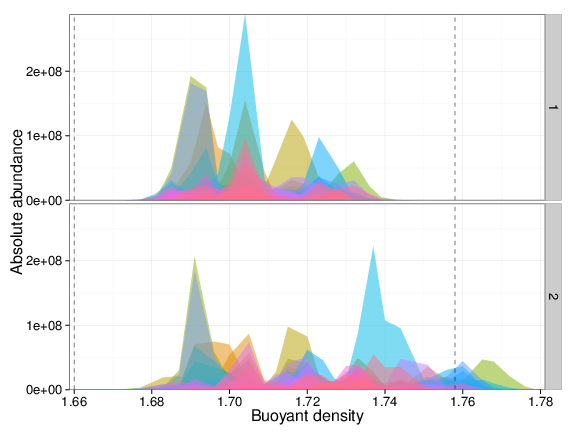

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/100/OTU_abs1e10_rel-abund.png


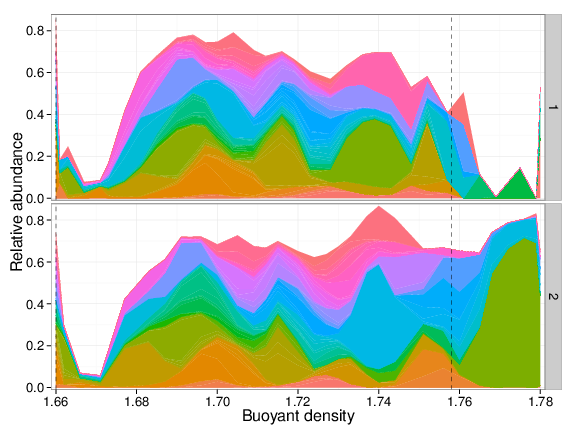

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/20/OTU_abs1e10_abs-abund.png


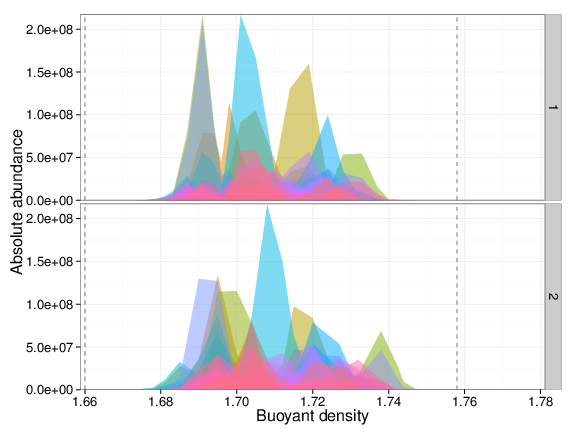

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/20/OTU_abs1e10_rel-abund.png


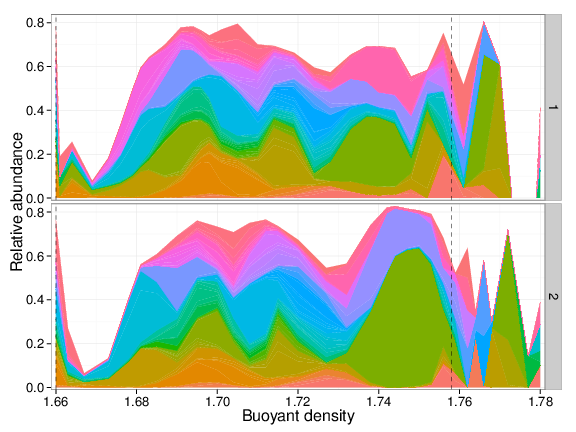

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/40/OTU_abs1e10_abs-abund.png


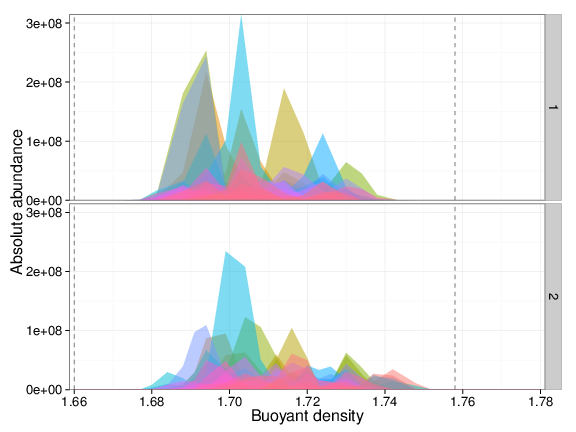

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/40/OTU_abs1e10_rel-abund.png


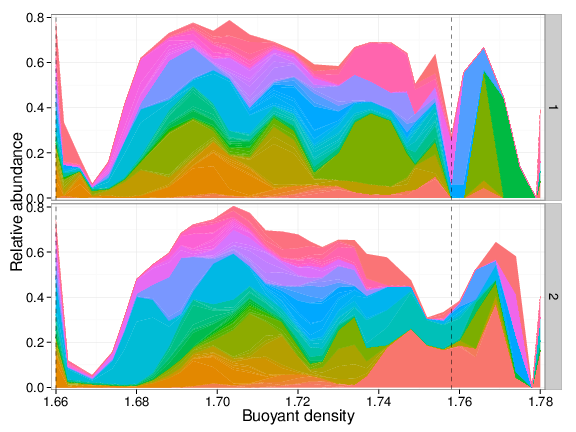

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/60/OTU_abs1e10_abs-abund.png


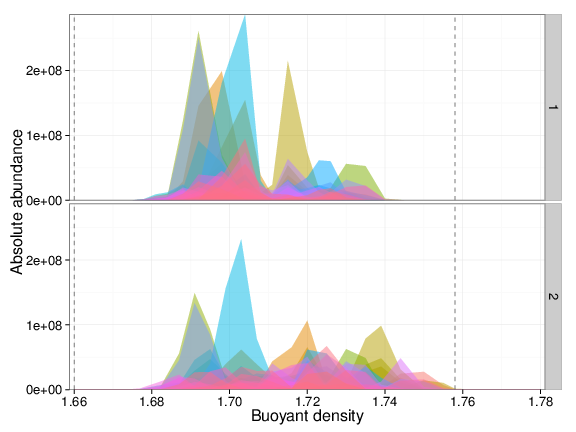

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/60/OTU_abs1e10_rel-abund.png


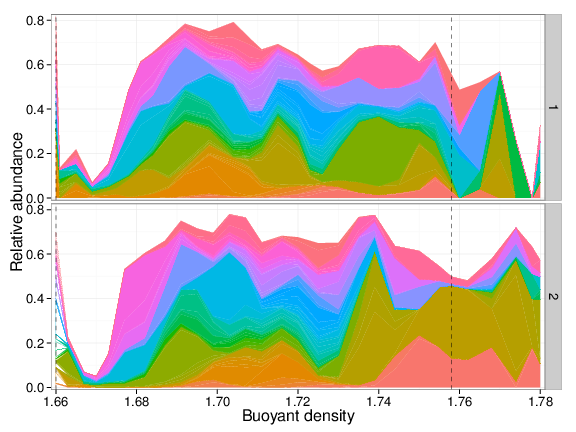

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/80/OTU_abs1e10_abs-abund.png


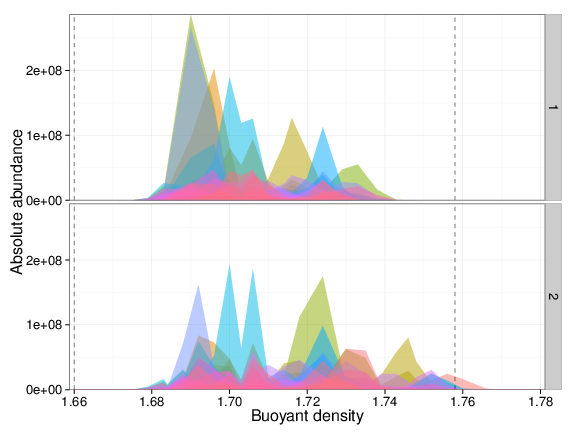

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/80/OTU_abs1e10_rel-abund.png


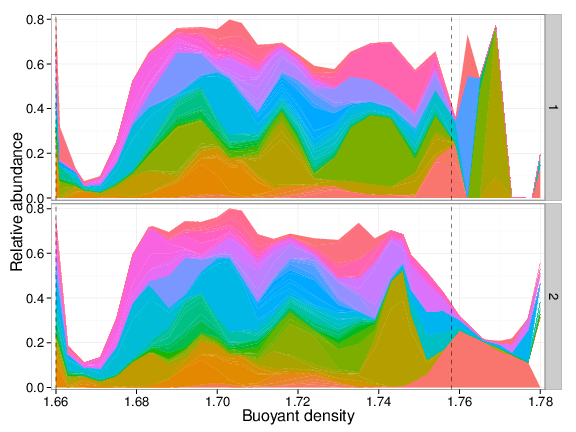

In [223]:
x = os.path.join(workDir, 'percIncorpUnif', '*', 'OTU_abs*abund.png')
abundFiles = glob.glob(x)

for x in sorted(abundFiles):
    print x
    img = Image(x)
    display(img)

#### Subsampled OTU tables

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/0/OTU_n2_abs1e10_subsub-norm_abs-abund.png


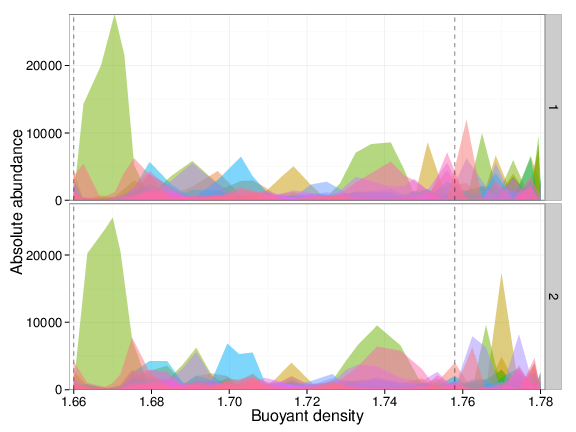

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/0/OTU_n2_abs1e10_subsub-norm_rel-abund.png


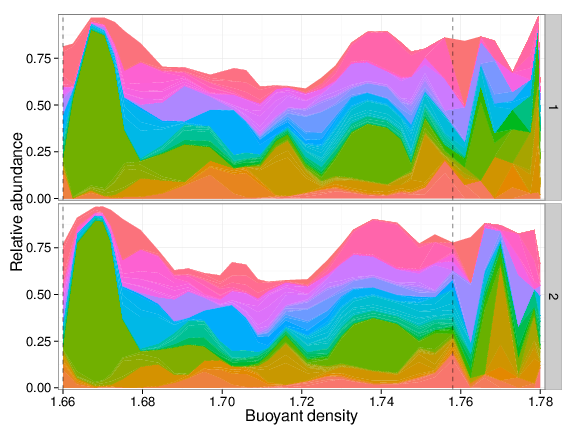

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/100/OTU_n2_abs1e10_subsub-norm_abs-abund.png


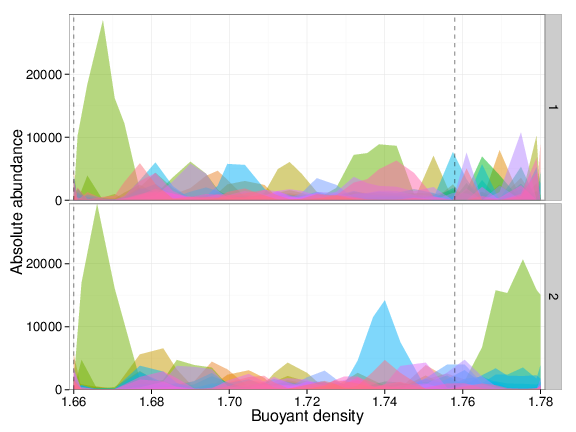

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/100/OTU_n2_abs1e10_subsub-norm_rel-abund.png


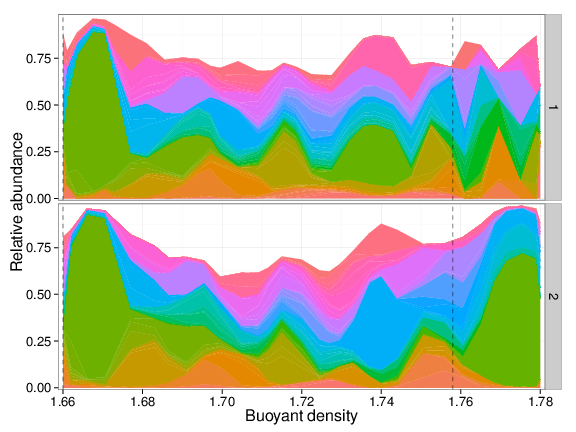

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/20/OTU_n2_abs1e10_subsub-norm_abs-abund.png


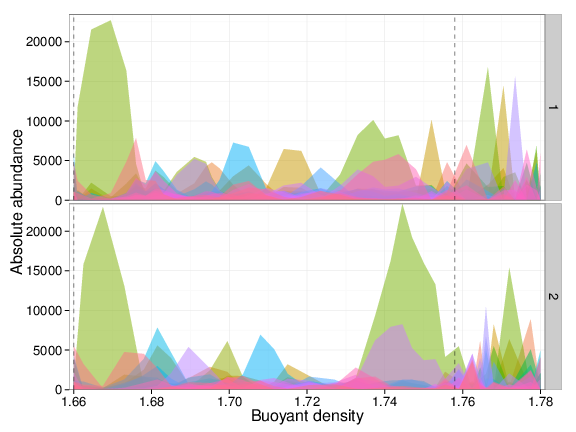

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/20/OTU_n2_abs1e10_subsub-norm_rel-abund.png


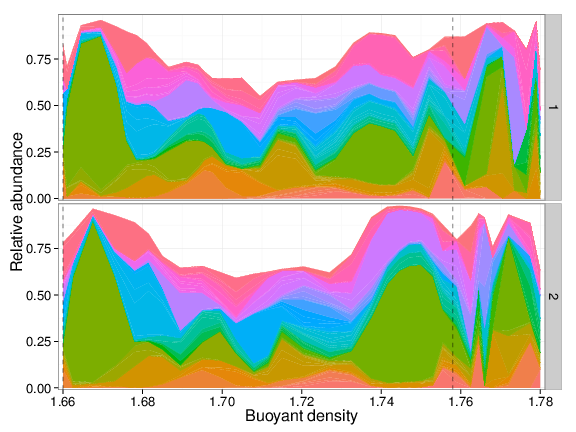

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/60/OTU_n2_abs1e10_subsub-norm_abs-abund.png


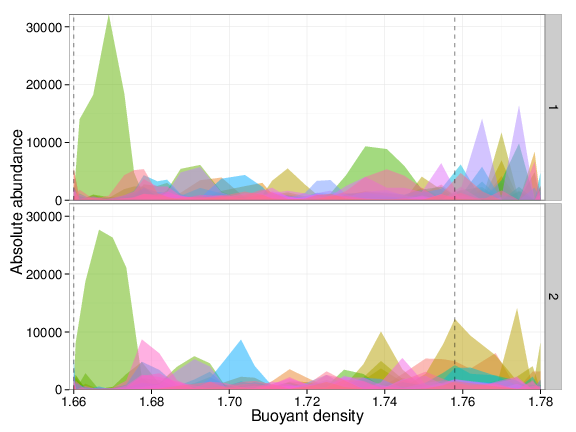

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/60/OTU_n2_abs1e10_subsub-norm_rel-abund.png


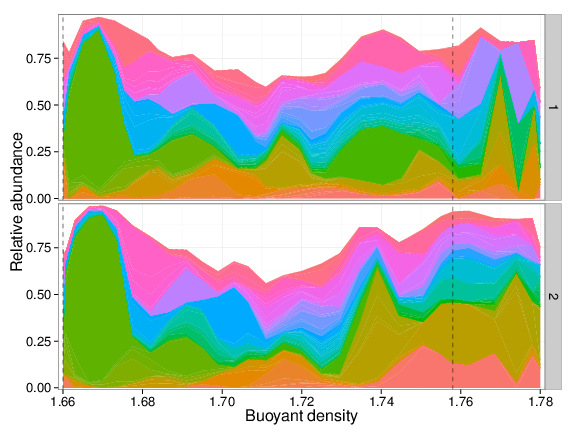

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/80/OTU_n2_abs1e10_subsub-norm_abs-abund.png


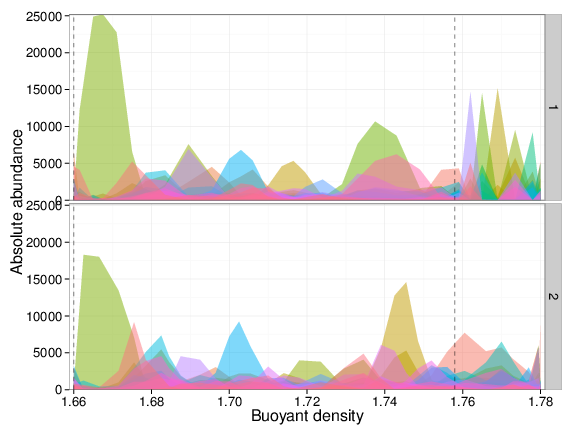

/home/nick/notebook/SIPSim/dev/bac_genome1210/percIncorpUnif/80/OTU_n2_abs1e10_subsub-norm_rel-abund.png


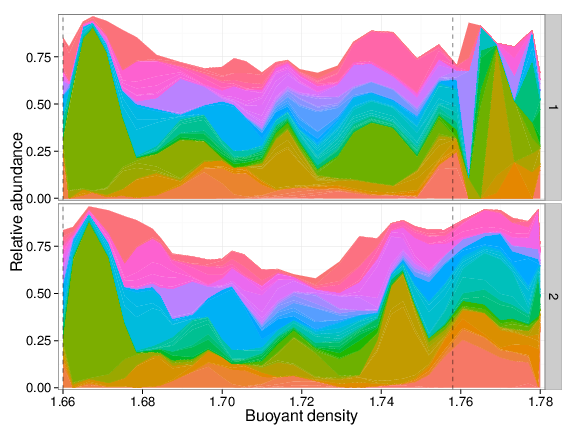

In [208]:
x = os.path.join(workDir, 'percIncorpUnif', '*', 'OTU*_sub*abund.png')
abundFiles = glob.glob(x)

for x in sorted(abundFiles):
    print x
    img = Image(x)
    display(img)

### Plotting results

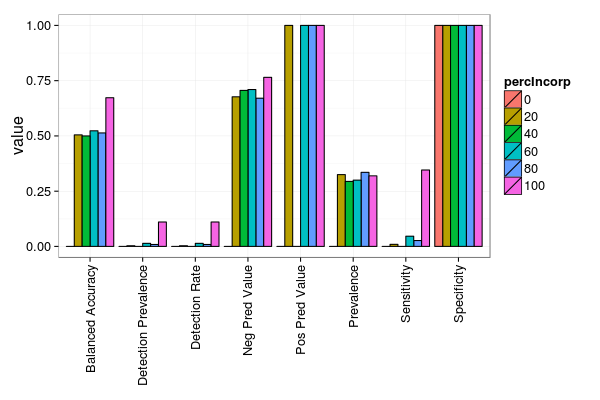

In [224]:
%%R -i workDir -w 600 -h 400
setwd(workDir)

byClass = read.csv('./percIncorpUnif/DESeq2-cMtx_byClass.csv')

byClass$byClass[is.na(byClass$byClass)] = 0

byClass$percIncorp = factor(byClass$percIncorp, 
                            levels=as.character(unique(sort(byClass$percIncorp))))
p = ggplot(byClass, aes(X, byClass, fill=percIncorp)) +
    geom_bar(stat='identity', position='dodge', color='black') +
    labs(y='value') +
    theme_bw() +
    theme(
        text=element_text(size=16),
        axis.text.x=element_text(angle=90, hjust=1, vjust=0.5),
        axis.title.x=element_blank()
        )
p

__Conclusions:__

* High specificity
* Fairly low sensitivity

### Enrichment of TP for abundant incorporators?

* What is the abundance distribution of TP and FP?
  * Are more abundant incorporators being detected more than low abundant taxa

In [12]:
%%R -i workDir

setwd(workDir)

tbl.c = read.csv('percIncorpUnif/100/DESeq2-cMtx_data.csv')
tbl.otu = read.delim('percIncorpUnif/100/OTU_n2_abs1e10_sub-norm.txt', sep='\t')

In [13]:
%%R
# OTU total counts
tbl.otu.sum = tbl.otu %>%
    group_by(library, taxon) %>%
    summarize(total_count = sum(count))
tbl.otu.sum %>% head

Source: local data frame [6 x 3]
Groups: library

  library                                taxon total_count
1       1       Acaryochloris_marina_MBIC11017         688
2       1       Acetobacterium_woodii_DSM_1030           4
3       1 Acetobacter_pasteurianus_IFO_3283-12         269
4       1    Acetohalobium_arabaticum_DSM_5501          19
5       1         Acholeplasma_laidlawii_PG-8A           4
6       1        Achromobacter_xylosoxidans_A8         947


In [14]:
%%R
# 
label.tp.fn = function(known, pred){
    if(is.na(known) | is.na(pred)){
        return(NA)
        } else
    if(known==TRUE & pred==TRUE){
        return('TP')
        } else
    if(known==TRUE & pred==FALSE){
        return('FN')
        } else {
        return(NA)
        }
    }

tbl.c.tp.fn = tbl.c %>% 
    mutate(tp.fn = mapply(label.tp.fn, incorp.known, incorp.pred)) %>%
    filter(! is.na(tp.fn))

tbl.tp.fn = inner_join(tbl.c.tp.fn, tbl.otu.sum, c('taxon' = 'taxon')) 
tbl.tp.fn %>% head

  lib1 lib2                                taxon  BD_shift incorp.known
1   NA    2   Actinobacillus_equuli_subsp_equuli 0.9998690         TRUE
2   NA    2   Actinobacillus_equuli_subsp_equuli 0.9998690         TRUE
3   NA    2 Rhodospirillum_photometricum_DSM_122 0.9994019         TRUE
4   NA    2 Rhodospirillum_photometricum_DSM_122 0.9994019         TRUE
5   NA    2       Clostridium_perfringens_str_13 0.9994113         TRUE
6   NA    2       Clostridium_perfringens_str_13 0.9994113         TRUE
    baseMean log2FoldChange    lfcSE      stat       pvalue        padj
1  0.4552057      6.2579798 1.766526 3.4010144 0.0003356814 0.004498131
2  0.4552057      6.2579798 1.766526 3.4010144 0.0003356814 0.004498131
3 45.3983812      0.5161328 1.281162 0.2077277 0.4177208036 1.000000000
4 45.3983812      0.5161328 1.281162 0.2077277 0.4177208036 1.000000000
5  0.2090181      5.0465047 2.030653 2.3620503 0.0090870878 0.086976412
6  0.2090181      5.0465047 2.030653 2.3620503 0.0090870878 0.08

In [15]:
%%R
# how many TP & FN?
tbl.tp.fn %>% 
    group_by(library, tp.fn) %>%
    summarize(n = n())

Source: local data frame [4 x 3]
Groups: library

  library tp.fn  n
1       1    FN 70
2       1    TP 37
3       2    FN 70
4       2    TP 37


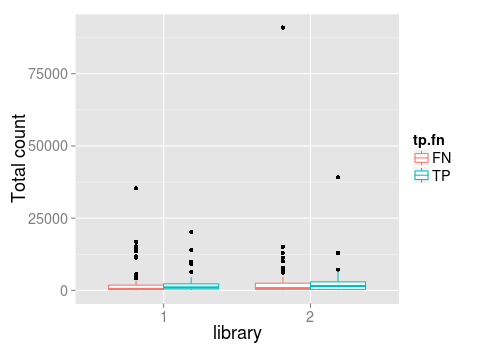

In [229]:
%%R -h 350
tbl.tp.fn$library = as.character(tbl.tp.fn$library)
ggplot(tbl.tp.fn, aes(library, total_count, color=tp.fn)) +
    geom_boxplot() +
    labs(y='Total count') +
    theme(
        text = element_text(size=18)
        )  

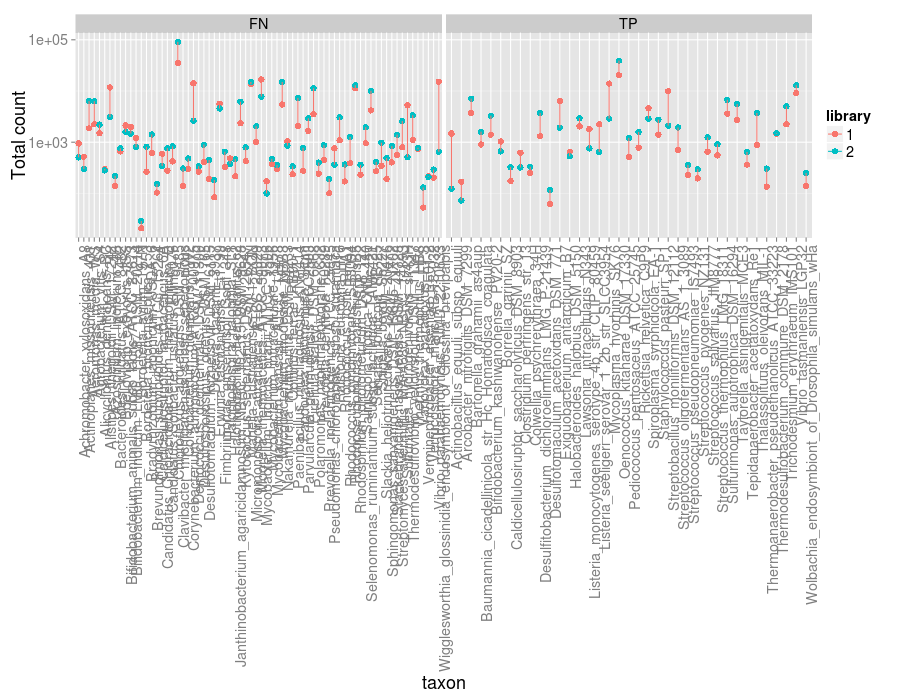

In [230]:
%%R -h 700 -w 900
tbl.tp.fn$library = as.character(tbl.tp.fn$library)
ggplot(tbl.tp.fn, aes(taxon, total_count, group=taxon, color=library)) +
    geom_point(size=3) +
    geom_line() +
    scale_y_log10() +
    labs(y='Total count') +
    facet_grid(. ~ tp.fn, scales='free_x') +
    theme(
        text = element_text(size=18),
        axis.text.x = element_text(angle=90, hjust=1)
        )  

__Notes:__

* FNs can be abundant
* __TP can have a lower abundance in the 'treatment' library__

### Just looking at the 'heavy' fractions

In [235]:
%%R
# OTU total counts

BD_min.cut = 1.71
BD_max.cut = 1.78


tbl.otu.sum = tbl.otu %>%
    filter(! grepl('inf', fraction)) %>%
    separate(fraction, into = c('BD_min','BD_max'), sep='-', convert=TRUE) %>%
    filter(BD_min >= BD_min.cut & BD_max <= BD_max.cut) %>%
    group_by(library, taxon) %>%
    summarize(total_count = sum(count))
tbl.otu.sum %>% head

Source: local data frame [6 x 3]
Groups: library

  library                                taxon total_count
1       1       Acaryochloris_marina_MBIC11017         641
2       1       Acetobacterium_woodii_DSM_1030           0
3       1 Acetobacter_pasteurianus_IFO_3283-12         210
4       1    Acetohalobium_arabaticum_DSM_5501           0
5       1         Acholeplasma_laidlawii_PG-8A           0
6       1        Achromobacter_xylosoxidans_A8         947


In [236]:
%%R

tbl.tp.fn = inner_join(tbl.c.tp.fn, tbl.otu.sum, c('taxon' = 'taxon')) 
tbl.tp.fn %>% head

  lib1 lib2                                taxon  BD_shift incorp.known
1   NA    2   Actinobacillus_equuli_subsp_equuli 0.9998690         TRUE
2   NA    2   Actinobacillus_equuli_subsp_equuli 0.9998690         TRUE
3   NA    2 Rhodospirillum_photometricum_DSM_122 0.9994019         TRUE
4   NA    2 Rhodospirillum_photometricum_DSM_122 0.9994019         TRUE
5   NA    2       Clostridium_perfringens_str_13 0.9994113         TRUE
6   NA    2       Clostridium_perfringens_str_13 0.9994113         TRUE
    baseMean log2FoldChange    lfcSE      stat       pvalue        padj
1  0.4552057      6.2579798 1.766526 3.4010144 0.0003356814 0.004498131
2  0.4552057      6.2579798 1.766526 3.4010144 0.0003356814 0.004498131
3 45.3983812      0.5161328 1.281162 0.2077277 0.4177208036 1.000000000
4 45.3983812      0.5161328 1.281162 0.2077277 0.4177208036 1.000000000
5  0.2090181      5.0465047 2.030653 2.3620503 0.0090870878 0.086976412
6  0.2090181      5.0465047 2.030653 2.3620503 0.0090870878 0.08

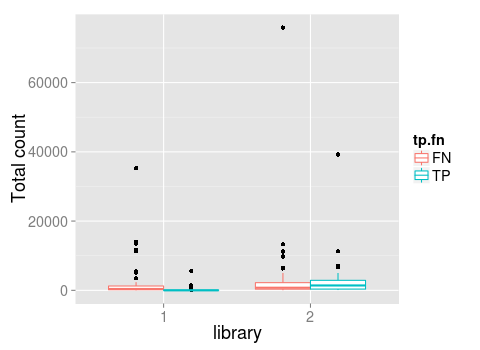

In [237]:
%%R -h 350
tbl.tp.fn$library = as.character(tbl.tp.fn$library)
ggplot(tbl.tp.fn, aes(library, total_count, color=tp.fn)) +
    geom_boxplot() +
    labs(y='Total count') +
    theme(
        text = element_text(size=18)
        )  

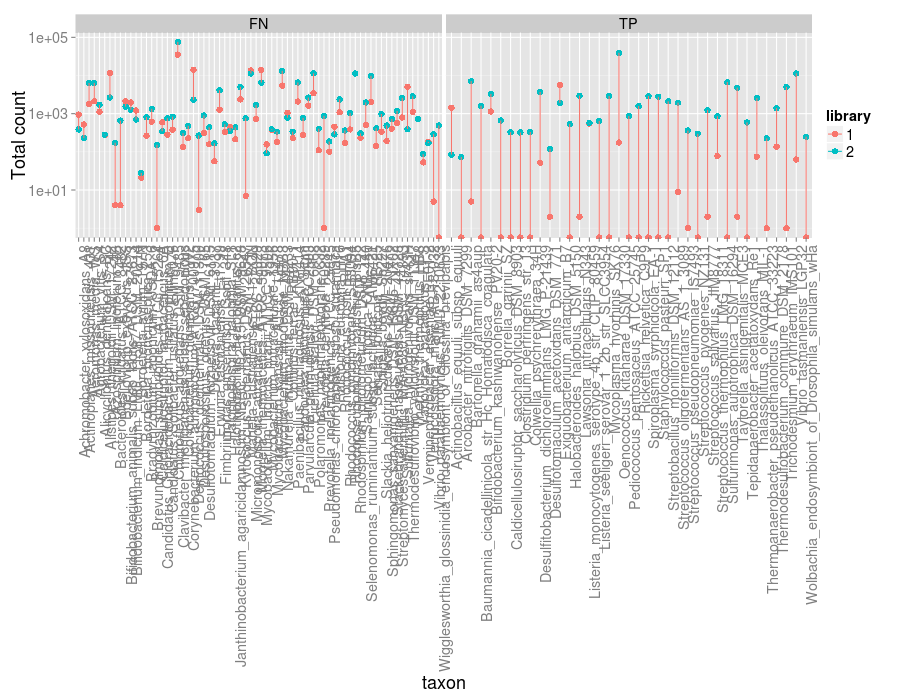

In [238]:
%%R -h 700 -w 900
tbl.tp.fn$library = as.character(tbl.tp.fn$library)
ggplot(tbl.tp.fn, aes(taxon, total_count, group=taxon, color=library)) +
    geom_point(size=3) +
    geom_line() +
    scale_y_log10() +
    labs(y='Total count') +
    facet_grid(. ~ tp.fn, scales='free_x') +
    theme(
        text = element_text(size=18),
        axis.text.x = element_text(angle=90, hjust=1)
        )  

__Notes:__

* The TPs (for the most part) are dramatically different in abundance between control and treatment
* Not sure about the 2 taxa with similar abundances in treatment & control heavy fractions
  * e.g., Desulfotomaculum
  * random chance? DESeq happend to get those right?

## Plotting the abundances of TP taxa

In [16]:
%%R -i workDir
setwd(workDir)

tbl.f = tbl.tp.fn %>% 
    filter(tp.fn == 'TP') %>%
    select(taxon) %>%
    distinct()

#write.csv(tbl.f, 'percIncorpUnif/100/TP.txt', sep='\t', row.names=F, col.names=F, quote=F)

tbl.f %>% head

                                  taxon
1    Actinobacillus_equuli_subsp_equuli
2        Clostridium_perfringens_str_13
3             Mycoplasma_hyorhinis_SK76
4             Rickettsia_helvetica_C9P9
5 Bifidobacterium_kashiwanohense_PV20-2
6           Staphylococcus_pasteuri_SP1


In [17]:
%%R


tbl.otu = read.delim('percIncorpUnif/100/OTU_n2_abs1e10_sub-norm.txt', sep='\t')

tbl.otu.f = tbl.otu %>%
    filter(taxon %in% tbl.f$taxon)

tbl.otu.f %>% nrow %>% print
tbl.otu.f %>% head

[1] 2368
  library    fraction                              taxon count
1       1  -inf-1.660 Actinobacillus_equuli_subsp_equuli     0
2       2  -inf-1.660 Actinobacillus_equuli_subsp_equuli    19
3       1 1.660-1.662 Actinobacillus_equuli_subsp_equuli     0
4       2 1.660-1.664 Actinobacillus_equuli_subsp_equuli     0
5       1 1.662-1.665 Actinobacillus_equuli_subsp_equuli     0
6       2 1.664-1.668 Actinobacillus_equuli_subsp_equuli     0


In [18]:
%%R

## BD min/max/mid
tbl.otu.f = tbl.otu.f %>%
  mutate(fraction = gsub('^-inf','negInf',fraction)) %>%
    separate(fraction, into = c('BD_min','BD_max'), sep='-',
             convert=TRUE, remove=FALSE) %>%
      mutate(BD_min = as.numeric(gsub('negInf','-inf',BD_min)),
             BD_max = as.numeric(gsub('negInf','-inf',BD_max)))

calc_BD_mid = function(BD_min, BD_max){
  if(is.infinite(BD_min)){
    return(BD_max)
  } else
    if(is.infinite(BD_max)){
      return(BD_min)
    } else {
      return((BD_max - BD_min) / 2 + BD_min)
    }
  stop('LOGIC error')
}
tbl.otu.f$BD_mid = mapply(calc_BD_mid,tbl.otu.f$BD_min, tbl.otu.f$BD_max)

calc_BD_width = function(BD_min, BD_max){
  if(is.infinite(BD_min)){
    return(0.001)
  } else
    if(is.infinite(BD_max)){
      return(0.001)
    } else {
      return(BD_max - BD_min)
    }
  stop('LOGIC error')
}
    
tbl.otu.f$BD_width = mapply(calc_BD_width,tbl.otu.f$BD_min, tbl.otu.f$BD_max)

    
    
tbl.otu.f %>% head

  library     fraction BD_min BD_max                              taxon count
1       1 negInf-1.660   -Inf  1.660 Actinobacillus_equuli_subsp_equuli     0
2       2 negInf-1.660   -Inf  1.660 Actinobacillus_equuli_subsp_equuli    19
3       1  1.660-1.662  1.660  1.662 Actinobacillus_equuli_subsp_equuli     0
4       2  1.660-1.664  1.660  1.664 Actinobacillus_equuli_subsp_equuli     0
5       1  1.662-1.665  1.662  1.665 Actinobacillus_equuli_subsp_equuli     0
6       2  1.664-1.668  1.664  1.668 Actinobacillus_equuli_subsp_equuli     0
  BD_mid BD_width
1 1.6600    0.001
2 1.6600    0.001
3 1.6610    0.002
4 1.6620    0.004
5 1.6635    0.003
6 1.6660    0.004


In [19]:
%%R

tbl.s = tbl.otu.f %>%
  group_by(library, BD_mid) %>%
    summarize(total_sample_count = sum(count))

tbl.otu.f = inner_join(tbl.otu.f, tbl.s, c('library'='library','BD_mid'='BD_mid'))
tbl.otu.f = tbl.otu.f %>%
  mutate(rel_count = count / total_sample_count)

tbl.otu.f %>% head

  library     fraction BD_min BD_max                              taxon count
1       1 negInf-1.660   -Inf  1.660 Actinobacillus_equuli_subsp_equuli     0
2       2 negInf-1.660   -Inf  1.660 Actinobacillus_equuli_subsp_equuli    19
3       1  1.660-1.662  1.660  1.662 Actinobacillus_equuli_subsp_equuli     0
4       2  1.660-1.664  1.660  1.664 Actinobacillus_equuli_subsp_equuli     0
5       1  1.662-1.665  1.662  1.665 Actinobacillus_equuli_subsp_equuli     0
6       2  1.664-1.668  1.664  1.668 Actinobacillus_equuli_subsp_equuli     0
  BD_mid BD_width total_sample_count   rel_count
1 1.6600    0.001               8391 0.000000000
2 1.6600    0.001               3199 0.005939356
3 1.6610    0.002               2593 0.000000000
4 1.6620    0.004                  0         NaN
5 1.6635    0.003               2917 0.000000000
6 1.6660    0.004                  0         NaN


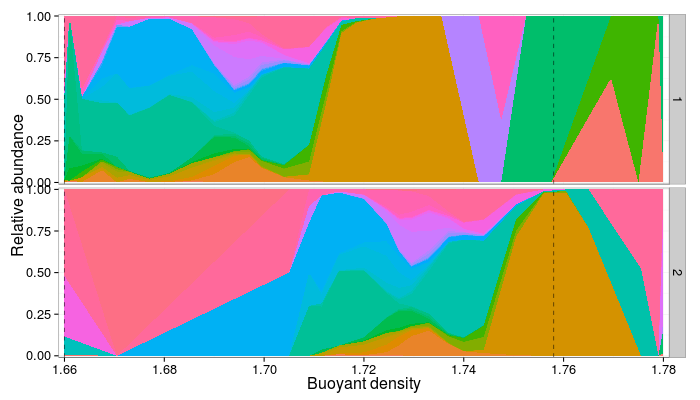

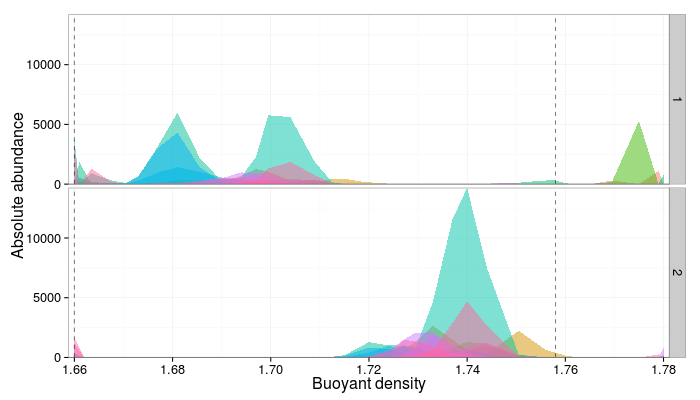

In [24]:
%%R -w 700 -h 400

make_frac_plot = function(tbl, BD.GCp0, BD.GCp100, rel=FALSE, legend=FALSE){
  p = ggplot(tbl, aes(x=BD_mid, fill=taxon))
  if(rel==TRUE){
    p = p + geom_area(aes(y=rel_count), stat='identity', alpha=1, position='stack') +
      labs(y='Relative abundance')
  } else {
    p = p + geom_area(aes(y=count), stat='identity', alpha=0.5, position='dodge') +
      labs(y='Absolute abundance')
  }
  p = p + geom_vline(xintercept=c(BD.GCp0, BD.GCp100), linetype='dashed', alpha=0.5) +
      labs(x='Buoyant density') +
        scale_x_continuous(expand=c(0.01,0)) +
          scale_y_continuous(expand=c(0,0.01)) +
            facet_grid(library ~ .) +
              theme_bw()

  if(legend==TRUE){
    p = p + theme(
      text = element_text(size=16)
    )
  } else {
    p = p + theme(
      text = element_text(size=16),
      legend.position = 'none'
    )
  }

  return(p)
}

BD.GCp0 = 0 * 0.098 + 1.66
BD.GCp100 = 1 * 0.098 + 1.66

p.dodge = make_frac_plot(tbl.otu.f, BD.GCp0, BD.GCp100)
p.fill = make_frac_plot(tbl.otu.f, BD.GCp0, BD.GCp100, rel=TRUE)

print(p.dodge)
print(p.fill)

***

# Sandbox

In [73]:
# building tree structure
from os.path import abspath
nest = nestly.Nest()

##  values
vals = [str(x) for x in range(1,5)]
nest.add('vals', vals)


## input files
nest.add('--np', [1], create_dir=False)

buildDir = '/home/nick/t/nestly/' #os.path.join(workDir, 'vals')
nest.build(buildDir)

In [74]:
%%writefile /home/nick/t/example.sh
#!/bin/bash

export TIME='elapsed,maxmem,exitstatus\n%e,%M,%x'

echo {--np} > {--np}_test.txt

Writing /home/nick/t/example.sh


In [75]:
!cd /home/nick/t/; \
    chmod 777 example.sh 

In [76]:
!cd /home/nick/t/; \
    nestrun -j 2 --template-file example.sh -d nestly

2015-06-24 12:13:25,688 * INFO * Template: ./example.sh
2015-06-24 12:13:25,690 * INFO * [204263] Started ./example.sh in nestly/3
2015-06-24 12:13:25,692 * INFO * [204264] Started ./example.sh in nestly/2
2015-06-24 12:13:25,692 * INFO * [204263] nestly/3 Finished with 0
2015-06-24 12:13:25,694 * INFO * [204265] Started ./example.sh in nestly/1
2015-06-24 12:13:25,694 * INFO * [204264] nestly/2 Finished with 0
2015-06-24 12:13:25,696 * INFO * [204266] Started ./example.sh in nestly/4
2015-06-24 12:13:25,696 * INFO * [204265] nestly/1 Finished with 0
2015-06-24 12:13:25,696 * INFO * [204266] nestly/4 Finished with 0
